In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
import statistics

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

## Data Preprocess

In [2]:
df = pd.read_csv('../Data-collection/final_df.csv')
df.head()

,grid,position,year,round,driver_age,driver_experience,driver_constructor_experience,driver_wins,constructor_wins,driver_points,...,constructor_manor,constructor_marussia,constructor_mclaren,constructor_mercedes,constructor_racing_point,constructor_red_bull,constructor_renault,constructor_sauber,constructor_toro_rosso,constructor_williams
0,4,3.0,2010,1,25,52,52,11.0,1.0,0.0,...,False,False,True,False,False,False,False,False,False,False
1,5,5.0,2010,1,24,70,0,0.0,0.0,0.0,...,False,False,False,True,False,False,False,False,False,False
2,3,1.0,2010,1,28,140,0,21.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,21,15.0,2010,1,28,52,0,1.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,9,11.0,2010,1,25,57,0,1.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,False


In [3]:
test_df = df[(df['year'] == 2023) | (df['year'] == 2024)].copy()
df = df[(df['year'] != 2023) & (df['year'] != 2024)].copy()

In [4]:
train_df = df.copy()

In [5]:
X_train = train_df.drop(columns=['position'])
X_test = test_df.drop(columns=['position'])

y_train = train_df['position']
y_test = test_df['position']

print(f"Training Features: {X_train.shape}, Testing Features: {X_test.shape}")
print(f"Training Target: {y_train.shape}, Testing Target: {y_test.shape}")

Training Features: (4305, 122), Testing Features: (780, 122)
Training Target: (4305,), Testing Target: (780,)


In [6]:
# Select only numerical columns for scaling
numerical_columns = [
    'grid', 'driver_age', 'driver_experience', 'driver_constructor_experience',
    'driver_points', 'driver_standing', 'constructor_points', 
    'constructor_standing', 'driver_wins', 'constructor_wins', 'circuit_danger', 
    'year', 'round'
]

scaler = StandardScaler()

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# convert one-hot-encoding columns from True/False to 1/0
all_columns = X_train.columns.tolist()
one_hot_columns = [col for col in all_columns if col not in numerical_columns]

X_train[one_hot_columns] = X_train[one_hot_columns].astype(int)
X_test[one_hot_columns] = X_test[one_hot_columns].astype(int)

## Testing functions

#### Regression

In [12]:
def accuracy_regression(trained_model): 
    
    df = test_df.copy()
    round_years = df['year'].unique()
    accuracy = []

    for round_year in round_years:
        df_current_year = df[df['year'] == round_year].copy()
        round_numbers = df_current_year['round'].unique()
        for round_number in round_numbers:
            df_current_round = df_current_year[df_current_year['round'] == round_number].copy()

            df_current_round[numerical_columns] = scaler.transform(df_current_round[numerical_columns])

            # Convert one-hot encoding columns from boolean to int
            one_hot_columns = [col for col in df_current_round.columns if df_current_round[col].dtype == 'bool']
            df_current_round[one_hot_columns] = df_current_round[one_hot_columns].astype(int)

            X_test_current_round = df_current_round.drop(columns=['position'])

            predictions_df = pd.DataFrame({'predicted_position': trained_model.predict(X_test_current_round)}) # Make predictions
            predictions_df.index = df_current_round.index # Ensure the indices align for merging
            df_current_round = pd.concat([df_current_round, predictions_df], axis=1) # Merge predictions back into the original DataFrame
        
            # Identify the predicted winner
            predicted_winner_idx = df_current_round['predicted_position'].idxmin()
            predicted_winner_row = df_current_round.loc[predicted_winner_idx]
            predicted_winner_name = next(col for col in one_hot_columns if predicted_winner_row[col] == 1)
            predicted_winner_name = predicted_winner_name.replace("driver_", "").replace("_", " ").title()
            predicted_winner_name = predicted_winner_name.split()[-1]
        
            # Identify the actual winner
            actual_winner_row = df_current_round[df_current_round['position'] == 1.0]
            if not actual_winner_row.empty:
                actual_winner_name = next(col for col in one_hot_columns if actual_winner_row.iloc[0][col] == 1)
                actual_winner_name = actual_winner_name.replace("driver_", "").replace("_", " ").title()
                actual_winner_name = actual_winner_name.split()[-1]
            else:
                actual_winner_name = "NaN"

            accuracy.append(predicted_winner_name == actual_winner_name)

    return statistics.mean(accuracy)

#### Classification

In [8]:
test_df_c = test_df.copy()
test_df_c['position'] = test_df_c['position'].apply(lambda x: 1 if x == 1.0 else 0)

In [13]:
def accuracy_classification(trained_model):

    df = test_df_c.copy()
    round_years = df['year'].unique()
    accuracy = []

    for round_year in round_years:
        df_current_year = df[df['year'] == round_year].copy()
        round_numbers = df_current_year['round'].unique()
        for round_number in round_numbers:
            df_current_round = df_current_year[df_current_year['round'] == round_number].copy()

            df_current_round[numerical_columns] = scaler.transform(df_current_round[numerical_columns])

            # Convert one-hot encoding columns from boolean to int
            one_hot_columns = [col for col in df_current_round.columns if df_current_round[col].dtype == 'bool']
            df_current_round[one_hot_columns] = df_current_round[one_hot_columns].astype(int)
            
            X_test_current_round = df_current_round.drop(columns=['position'])

            # Get probabilities and predictions    
            probabilities = trained_model.predict_proba(X_test_current_round)  # Probabilities for each class
            predicted_class = trained_model.predict(X_test_current_round)  # Predicted class (1 or 0)

            df_current_round = df_current_round.copy()

            # Add probabilities and predictions to the DataFrame
            df_current_round['probability_winner'] = probabilities[:, 1]  # Probability for class `1` (winner)
            df_current_round['predicted_class'] = predicted_class

            # Identify the predicted winner
            if (df_current_round['predicted_class'] == 1).sum() > 1:
                # If multiple winners, choose the one with the highest probability
                predicted_winner_idx = df_current_round[df_current_round['predicted_class'] == 1]['probability_winner'].idxmax()
            elif (df_current_round['predicted_class'] == 1).sum() == 1:
                # If only one winner
                predicted_winner_idx = df_current_round[df_current_round['predicted_class'] == 1].index[0]
            else:
                # If no winners, assign default values
                predicted_winner_idx = None
        
            if predicted_winner_idx is not None:
                predicted_winner_row = df_current_round.loc[predicted_winner_idx]
                predicted_winner_name = next(col for col in one_hot_columns if predicted_winner_row[col] == 1)
                predicted_winner_name = predicted_winner_name.replace("driver_", "").replace("_", " ").title()
                predicted_winner_name = predicted_winner_name.split()[-1]
            else:
                predicted_winner_name = "--"

            # Identify the actual winner
            actual_winner_row = df_current_round[df_current_round['position'] == 1.0]
            if not actual_winner_row.empty:
                actual_winner_name = next(col for col in one_hot_columns if actual_winner_row.iloc[0][col] == 1)
                actual_winner_name = actual_winner_name.replace("driver_", "").replace("_", " ").title()
                actual_winner_name = actual_winner_name.split()[-1]
            else:
                actual_winner_name = "NaN"

            accuracy.append(predicted_winner_name == actual_winner_name)
    
    return statistics.mean(accuracy)

## Regression Approach

#### Linear Regression

In [14]:
params = {'fit_intercept': [True, False]} 

best_score = -1.0
best_model = None

for fit_intercept in params['fit_intercept']:

    current_model = LinearRegression(fit_intercept=fit_intercept)
    current_model.fit(X_train, y_train)
    
    current_score = accuracy_regression(current_model)
    
    if current_score > best_score:
        best_score = current_score
        best_model = current_model

reg_lr_model = best_model

#### Random Forest

In [15]:
params={'n_estimators': [10, 50, 100],
        'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
        'max_features': [0.8, 'sqrt', 'log2', None]}

best_score = -1.0
best_model = None

for n_estimators in params['n_estimators']:
    for criterion in params['criterion']:
        for max_features in params['max_features']:

            current_model = RandomForestRegressor(n_estimators=n_estimators,
                                                criterion = criterion,
                                                max_features = max_features, 
                                                random_state = 1)
            current_model.fit(X_train, y_train)

            current_score = accuracy_regression(current_model)
    
            if current_score > best_score:
                best_score = current_score
                best_model = current_model


reg_rf_model = best_model

#### Support Vector Machines (SVM)

In [16]:
params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'gamma': ['scale', 'auto']}

best_score = -1.0
best_model = None

for kernel in params['kernel']:
    for gamma in params['gamma']:

        current_model = SVR(kernel=kernel, gamma=gamma)
        current_model.fit(X_train, y_train)

        current_score = accuracy_regression(current_model)
    
        if current_score > best_score:
            best_score = current_score
            best_model = current_model

reg_svm_model = best_model

#### Decision Tree

In [17]:
params = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best', 'random'],
    'max_features': ['sqrt', 'log2', None]
    }

best_score = -1.0
best_model = None

for criterion in params['criterion']:
    for splitter in params['splitter']:
        for max_features in params['max_features']:

            current_model = DecisionTreeRegressor(criterion=criterion, splitter=splitter, max_features=max_features)
            current_model.fit(X_train, y_train)

            current_score = accuracy_regression(current_model)
    
            if current_score > best_score:
                best_score = current_score
                best_model = current_model



reg_dt_model = best_model

#### K-Nearest Neighbor (KNN)

In [18]:
params = {
    'n_neighbors': [1, 2, 3, 5, 7, 10],
    'weights': ['uniform', 'distance', None],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

best_score = -1.0
best_model = None

for n_neighbors in params['n_neighbors']:
    for weights in params['weights']:
        for algorithm in params['algorithm']:

            current_model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)
            current_model.fit(X_train, y_train)

            current_score = accuracy_regression(current_model)
    
            if current_score > best_score:
                best_score = current_score
                best_model = current_model

reg_knn_model = best_model

#### Lasso

In [19]:
params = {'alpha': [0.1, 0.2, 0.3, 0.5, 1.0, 2.0, 3.0],
          'fit_intercept': [True, False],
          'max_iter': [500, 1000, 2000],
          'selection': ['cyclic', 'random']}

best_score = -1.0
best_model = None

for alpha in params['alpha']:
    for fit_intercept in params['fit_intercept']:
        for max_iter in params['max_iter']:
            for selection in params['selection']:

                current_model = Lasso(alpha=alpha, fit_intercept=fit_intercept, max_iter=max_iter, selection=selection)
                current_model.fit(X_train, y_train)

                current_score = accuracy_regression(current_model)

                if current_score > best_score:
                    best_score = current_score
                    best_model = current_model


reg_lasso_model = best_model

## Classification Approach

In [20]:
y_train_c = y_train.copy()
y_test_c = y_test.copy()
y_train_c = y_train_c.apply(lambda x: 1 if x == 1 else 0)
y_test_c = y_test_c.apply(lambda x: 1 if x == 1 else 0)

#### Logistic Regression 

In [21]:
params = {'penalty': [None], 
          'fit_intercept': [True, False],
          'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
          'max_iter': [50, 100, 200],
          'class_weight': [{0: 1, 1: 20}, 'balanced'] 
          } # penalty: 'l1', 'l2', 'elasticnet' ; solver: liblinear

best_score = -1.0
best_model = None

for penalty in params['penalty']:
    for fit_intercept in params['fit_intercept']:
        for solver in params['solver']:
            for max_iter in params['max_iter']:
                for class_weight in params['class_weight']:

                    current_model = LogisticRegression(penalty=penalty, 
                                                    fit_intercept=fit_intercept, 
                                                    solver=solver, 
                                                    class_weight=class_weight, 
                                                    max_iter=max_iter)
                    current_model.fit(X_train, y_train_c)

                    current_score = accuracy_classification(current_model)
    
                    if current_score > best_score:
                        best_score = current_score
                        best_model = current_model

cla_lr_model = best_model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

#### Decision Tree

In [22]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_features': ['sqrt', 'log2', None],
    'random_state': [1, None],
    'class_weight': [{0: 1, 1: 20}, 'balanced'] 
}

best_score = -1.0
best_model = None

for criterion in params['criterion']:
    for splitter in params['splitter']:
        for max_features in params['max_features']:
            for random_state in params['random_state']:
                for class_weight in params['class_weight']:

                    current_model = DecisionTreeClassifier(
                        criterion=criterion,
                        splitter=splitter,
                        max_features=max_features,
                        random_state=random_state,
                        class_weight=class_weight
                    )
                    current_model.fit(X_train, y_train_c)

                    current_score = accuracy_classification(current_model)
    
                    if current_score > best_score:
                        best_score = current_score
                        best_model = current_model

cla_dt_model = best_model

#### Support Vector Machines (SVM)

In [23]:
params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1], 
    'class_weight': [{0: 1, 1: 20}, 'balanced'] 
}

best_score = -1.0
best_model = None

for kernel in params['kernel']:
    for gamma in params['gamma']:
        for weight in params['class_weight']:
            current_model = SVC(
                kernel=kernel, 
                gamma=gamma, 
                probability=True,
                class_weight=weight, 
                random_state=42
            )
            current_model.fit(X_train, y_train_c)
                
            current_score = accuracy_classification(current_model) 
                
            if current_score > best_score:
                best_score = current_score
                best_model = current_model

cla_svm_model = best_model

#### Random Forest

In [24]:
params={'n_estimators': [10, 50, 100],
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_features': [0.8, 'sqrt', 'log2', None],
        'class_weight': [{0: 1, 1: 20}, 'balanced', 'balanced_subsample'] 
        }

best_score = -1.0
best_model = None

for n_estimators in params['n_estimators']:
    for criterion in params['criterion']:
        for max_features in params['max_features']:
            for class_weight in params['class_weight']:

                current_model = RandomForestClassifier(n_estimators=n_estimators,
                                                    criterion = criterion,
                                                    max_features = max_features, 
                                                    random_state = 1,
                                                    class_weight=class_weight)
                current_model.fit(X_train, y_train_c)

                current_score = accuracy_classification(current_model)
    
                if current_score > best_score:
                    best_score = current_score
                    best_model = current_model

cla_rf_model = best_model

#### K-Nearest Neighbor (KNN)

In [25]:
params={
    'n_neighbors': [1, 2, 3, 5, 7, 10],
    'weights': ['uniform', 'distance', None],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'] 
}

best_score = -1.0
best_model = None

for n_neighbors in params['n_neighbors']:
    for weights in params['weights']:
        for algorithm in params['algorithm']:

            current_model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)
            current_model.fit(X_train, y_train_c)

            current_score = accuracy_classification(current_model)
    
            if current_score > best_score:
                best_score = current_score
                best_model = current_model

cla_knn_model = best_model

#### Naïve Bayes

In [26]:
cla_nb_model = GaussianNB()
cla_nb_model.fit(X_train, y_train_c)

print(accuracy_classification(cla_nb_model))

0.045454545454545456


## Metrics

### Regression models

In [27]:
reg_models = [
    ("Linear Regression", "reg_lr_model"),
    ("Random Forest", "reg_rf_model"),
    ("SVM", "reg_svm_model"),
    ("Decision Tree", "reg_dt_model"),
    ("KNN", "reg_knn_model"),
    ("Lasso", "reg_lasso_model")
]

reg_models_accuracy = pd.DataFrame(columns=['model_name', 'accuracy'])

for model_name, model_var_name in reg_models:

    model_var = globals()[model_var_name]
    model_acc = accuracy_regression(model_var)

    new_row = pd.DataFrame({'model_name': [model_name], 'accuracy': [model_acc]})
    reg_models_accuracy = pd.concat([reg_models_accuracy, new_row], ignore_index=True)

print(reg_models_accuracy)

/var/folders/4z/6wzfzsy94r16_shjk6y6ndmc0000gn/T/ipykernel_79525/4204500874.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reg_models_accuracy = pd.concat([reg_models_accuracy, new_row], ignore_index=True)


          model_name  accuracy
0  Linear Regression  0.613636
1      Random Forest  0.659091
2                SVM  0.590909
3      Decision Tree  0.590909
4                KNN  0.613636
5              Lasso  0.636364


### Classification models

In [28]:
cla_models = [
    ("Logistic Regression", "cla_lr_model"),
    ("Decision Tree", "cla_dt_model"),
    ("SVM", "cla_svm_model"),
    ("Random Forest", "cla_rf_model"),
    ("KNN", "cla_knn_model"),
    ("GaussianNB", "cla_nb_model")]

cla_models_accuracy = pd.DataFrame(columns=['model_name', 'accuracy'])

for model_name, model_var_name in cla_models:

    model_var = globals()[model_var_name]
    model_acc = accuracy_classification(model_var)

    new_row = pd.DataFrame({'model_name': [model_name], 'accuracy': [model_acc]})
    cla_models_accuracy = pd.concat([cla_models_accuracy, new_row], ignore_index=True)

print(cla_models_accuracy)

/var/folders/4z/6wzfzsy94r16_shjk6y6ndmc0000gn/T/ipykernel_79525/3517978691.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cla_models_accuracy = pd.concat([cla_models_accuracy, new_row], ignore_index=True)


            model_name  accuracy
0  Logistic Regression  0.613636
1        Decision Tree  0.522727
2                  SVM  0.613636
3        Random Forest  0.522727
4                  KNN  0.613636
5           GaussianNB  0.045455


### Plot comparison

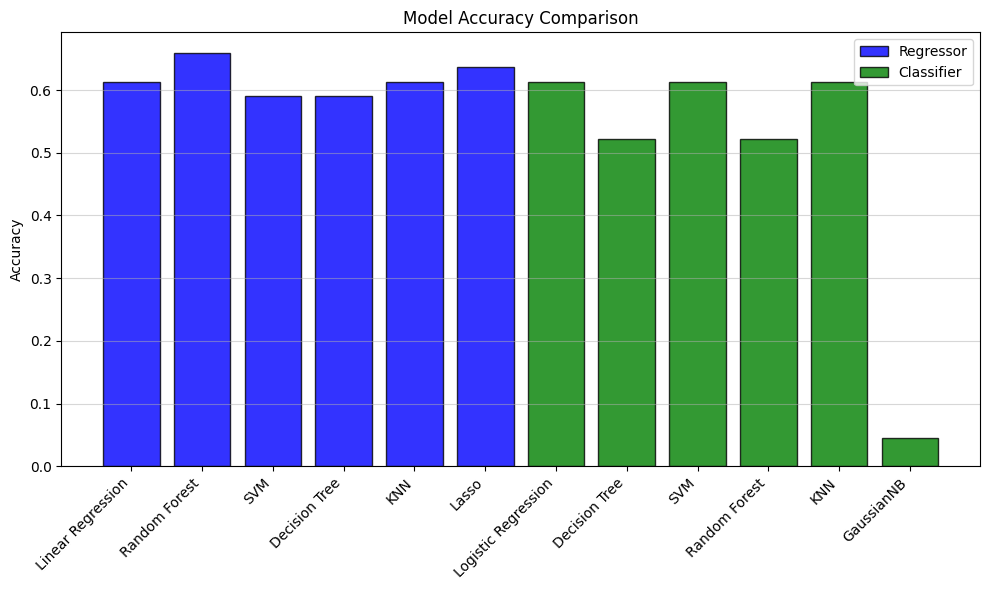

In [33]:
# Combine both DataFrames into one for easier plotting
reg_models_accuracy['type'] = 'Regressor'
cla_models_accuracy['type'] = 'Classifier'
combined_df = pd.concat([reg_models_accuracy, cla_models_accuracy])

x_labels = combined_df['model_name'].values
x_indices = np.arange(len(x_labels))
bar_colors = combined_df['type'].map({'Regressor': 'blue', 'Classifier': 'green'})

plt.figure(figsize=(10, 6))
plt.bar(x_indices, combined_df['accuracy'], color=bar_colors, alpha=0.8, edgecolor='black')

plt.xticks(x_indices, x_labels, rotation=45, ha='right', fontsize=10)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

handles = [
    plt.Rectangle((0, 0), 1, 1, facecolor='blue', alpha=0.8, edgecolor='black', label='Regressor'),
    plt.Rectangle((0, 0), 1, 1, facecolor='green', alpha=0.8, edgecolor='black', label='Classifier')
]
plt.legend(handles=handles, loc='upper right')

plt.grid(axis='y', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

## Save The model & scaler

In [ ]:
joblib.dump(reg_rf_model, 'trained_model.pkl') # TODO: use the best model dinamically
joblib.dump(scaler, 'scaler.pkl')

['trained_model.pkl']